# 설정

In [2]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "simple_classification_algorithm_training"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 장에서는 분류를 위한 초창기 머신 러닝 알고리즘인 퍼셉트론과 적응형 선형 뉴런 두 개를 사용한다. 파이썬으로 단계적으로 퍼셉트론을 구현하고 붓꽃 데이터셋에서 훈련하여 꽃 품종을 분류한다. 분류를 위한 머신 러닝 알고리즘 개념을 이해하고, 파이썬을 사용한 효율적인 구현 방법을 익히는 데 도움이 될 것이다.

적응형 선형 뉴런으로는 기본적인 최적화를 설명한다. 이는 후에 사이킷런의 강력한 분류 모델을 사용하는 기초를 다질 수 있을 것이다.

이 장에서는 다음 주제를 다룬다.
<ul>
    <li>머신 러닝 알고리즘을 직관적으로 이해하기</li>
    <li>판다스, 넘파이, 맷플롯립으로 데이터를 읽고 처리하고 시각화하기</li>
    <li>파이썬으로 선형 분류 알고리즘 구현하기</li>
</ul>

In [34]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

# 적응형 선형 뉴런과 학습의 수렴

이 절에서 단일층 신경망의 또 다른 종류인 <b>적응형 선형 뉴런</b><sup>ADAptive LInear NEuron, ADALINE</sup>을 살펴보겠다. 버나드 위드로우<sup>Bernard Widrow</sup>와 그의 박사 과정 학생인 테드 호프<sup>Tedd Hoff</sup>가 프랑크 로젠블라트의 퍼셉트론 알고리즘 이후 채 몇 년이 지나지 않아 <b>아달린</b><sup>Adaline</sup>을 발표했다.<sup id="a07">[7](#p07)</sup> 아달린은 퍼셉트론의 향상된 버전으로 볼 수 있다.

아달린은 연속 함수<sup>continuous function</sup>로 비용 함수를 정의하고 최소화하는 핵심 개념을 보여 주기 때문에 아주 흥미롭다. 후에 설명할 로지스틱 회귀<sup>logistic regression</sup>, 서포트 벡터 머신<sup>support vector machine</sup> 같은 분류를 위한 고급 머신 러닝 모델과 회귀 모델을 이해하는 데 도움이 될 것이다.

아달린 규칙(위드로우-호프 규칙이라고도 함)과 로젠블라트 퍼셉트론의 가장 큰 차이점은 가중치를 업데이트하는 데 퍼셉트론처럼 단위 계단 함수 대신 선형 활성화 함수를 사용하는 것이다.

아달린에서 선형 활성화 함수 <i>Φ(z)</i>는 최종 입력과 동일한 함수이다. 즉, 다음과 같다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Adaline_act.png">
</div>

선형 활성화 함수가 가중치 학습에 사용되지만 최종 예측을 만드는 데 여전히 임계 함수를 사용한다. 앞서 보았던 단위 계단 함수와 비슷하다. 퍼셉트론과 아달린 알고리즘의 주요 차이점을 다음 그림에 타나냈다.

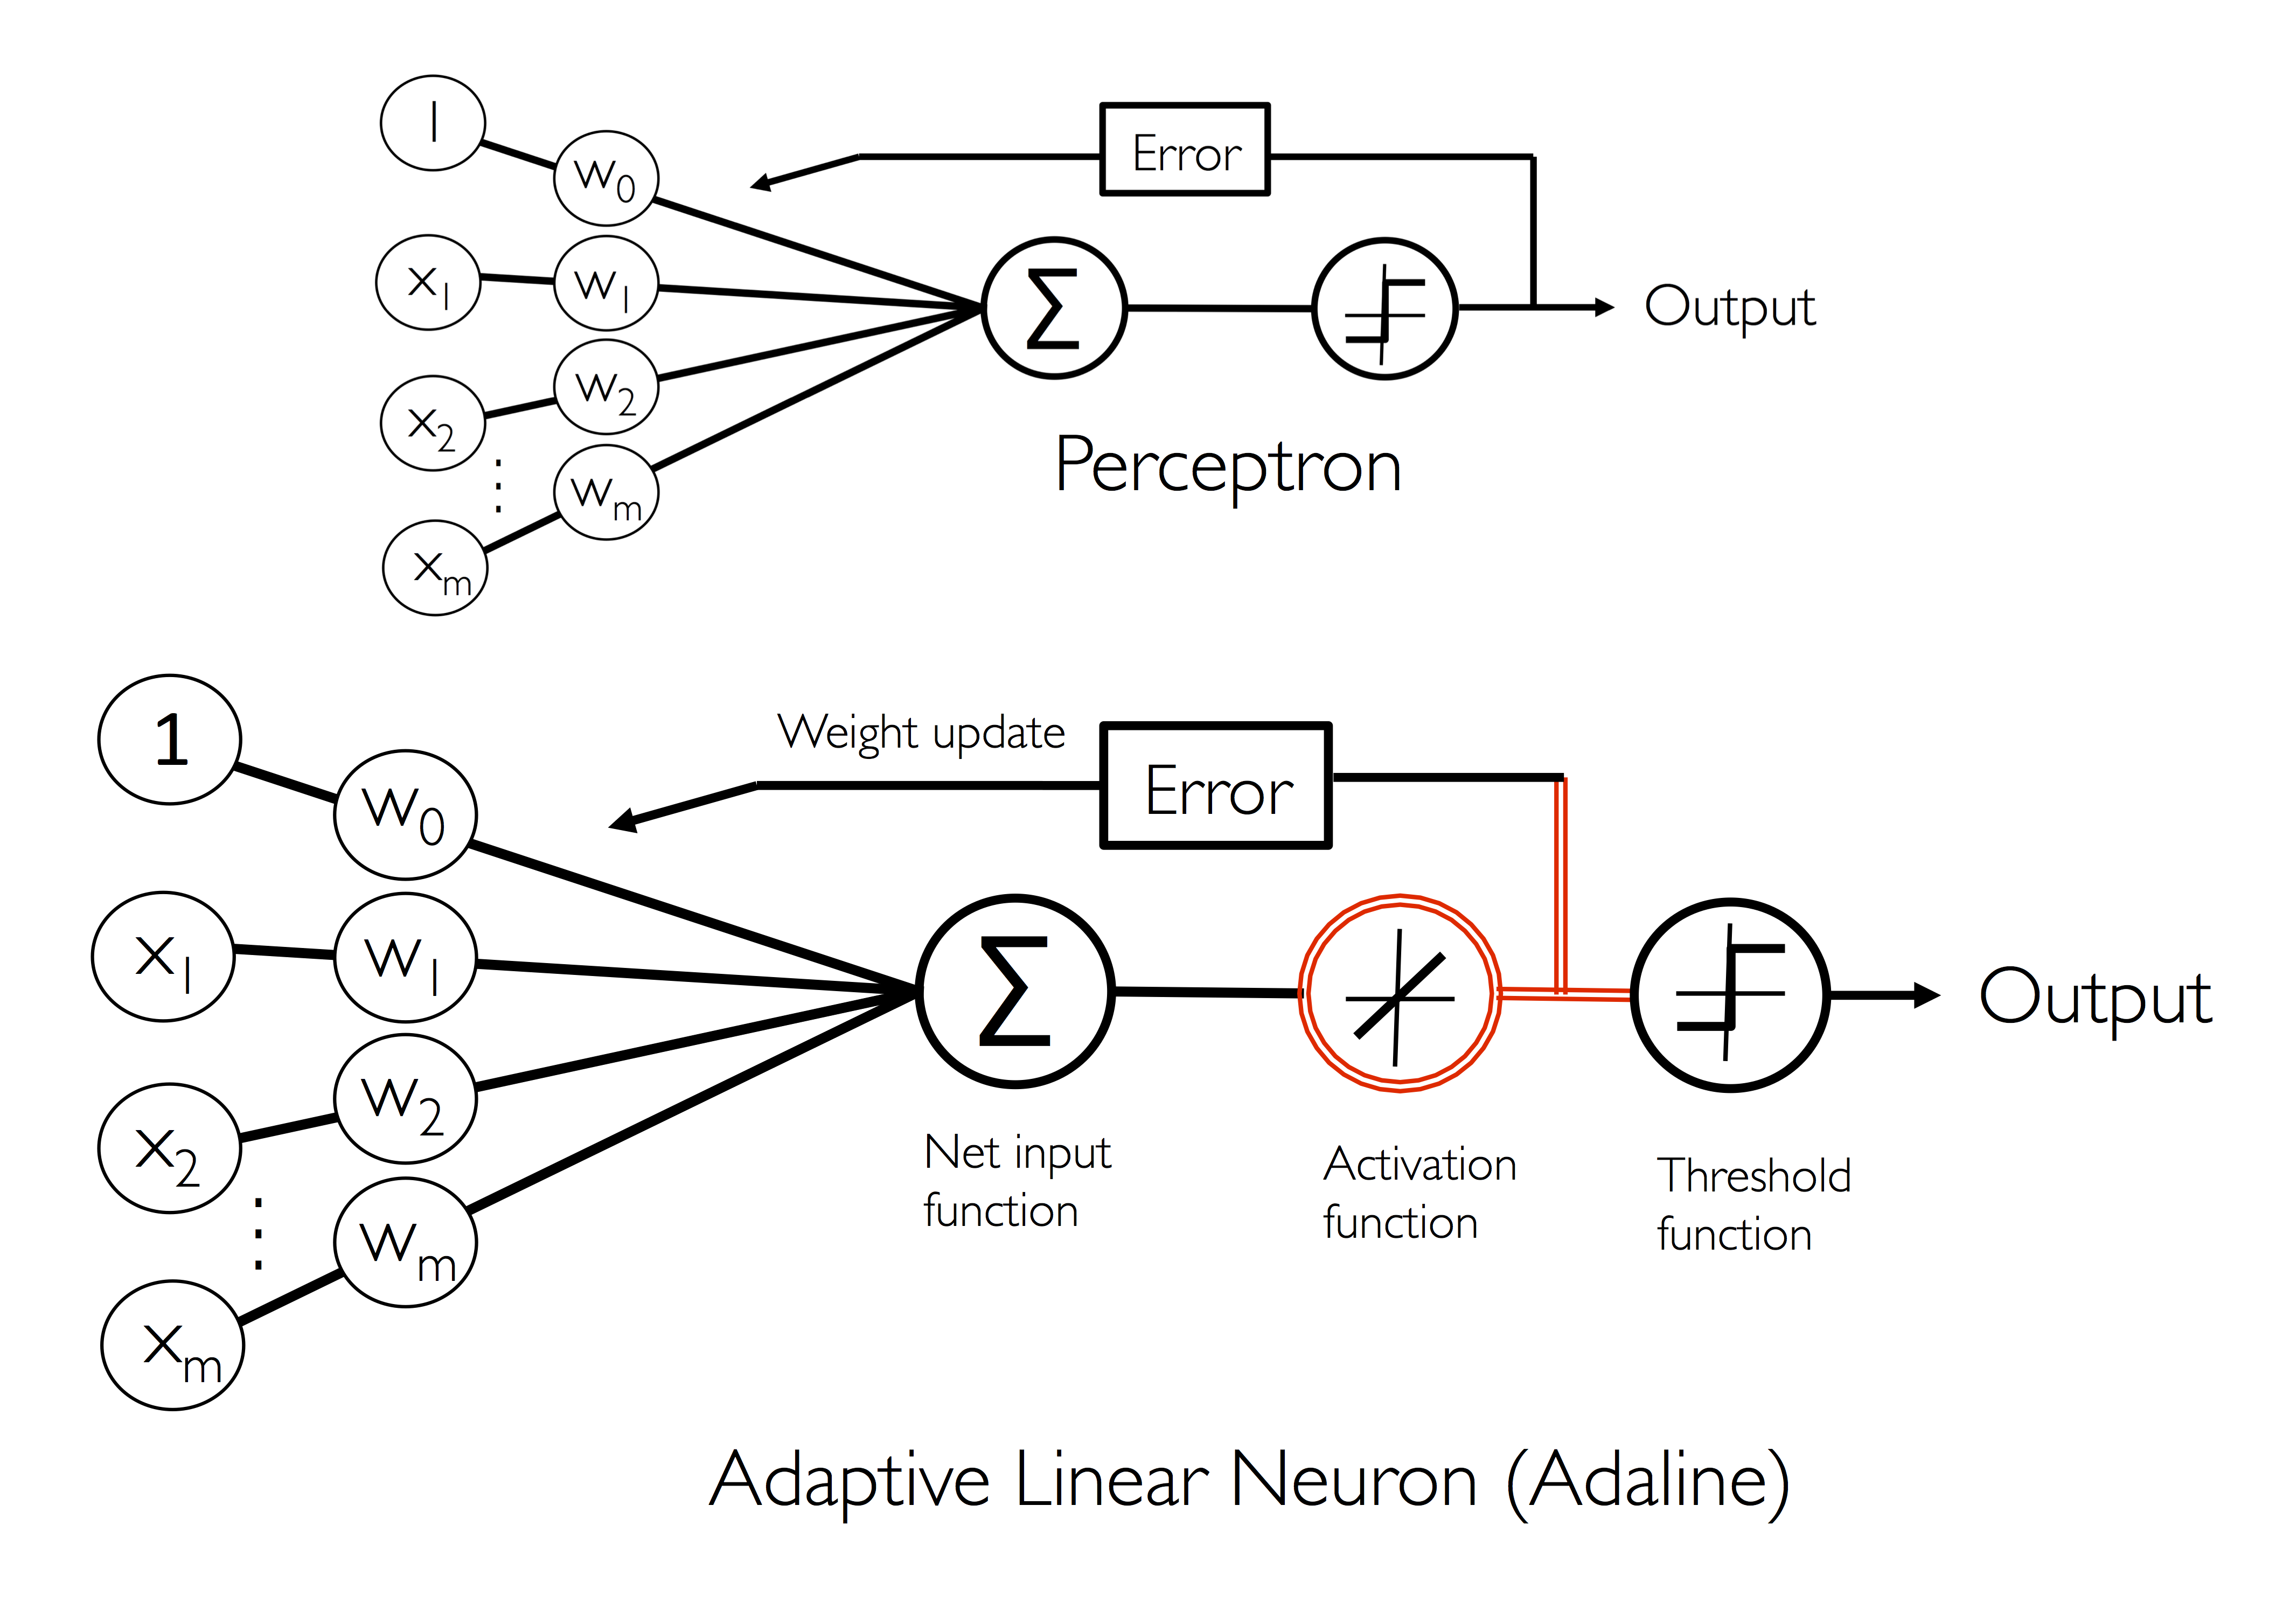

아달린 알고리즘은 진짜 클래스 레이블과 선형 활성화 함수의 실수 출력 값을 비교하여 모델의 오차를 계산하고 가중치를 업데이트한다. 반대로 퍼셉트론은 진짜 클래스 레이블과 예측 클래스 레이블을 비교한다.

## 경사 하강법으로 비용 함수 최소화

지도 학습 알고리즘의 핵심 구성 요소는 학습 과정 동안 최적화하기 위해 정의한 <b>목적 함수</b><sup>object function</sup>이다. 종종 최소화하려는 비용 함수는 목적 함수가 된다. 아달린은 계산된 출력과 진짜 클래스 레이블 사이의 <b>제곱 오차합</b><sup>Sum of Squared Errors, SSE</sup>으로 가중치를 학습할 비용 함수 <i>J</i>를 정의한다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Adaline_cost_func.png">
</div>

1/2 항은 다음 문단에서 설명할 그래디언트<sup>gradient</sup>를 간소하게 만들려고 편의상 추가한 것이다. 단위 계단 함수 대신 연속적인 선형 활성화 함수를 사용하는 장점은 비용 함수가 미분 가능해진다는 것이다. 이 비용 함수의 또 다른 장점은 볼록 함수라는 것이다. 간단하지만 강력한 최적화 알고리즘인 <b>경사 하강법</b><sup>gradient descent</sup>을 적용하여 붓꽃 데이터셋의 샘플을 분류하도록 비용 함수를 최소화하는 가중치를 찾을 수 있다.

다음 그림에서는 경사 하강법 이면에 있는 핵심 아이디어를 지역 또는 전역 최솟값에 도달할 때까지 언덕을 내려오는 것으로 묘사하고 있다. 각 반복에서 경사의 반대 방향으로 진행한다. 진행 크기는 경사의 기울기와 학습률로 결정한다.

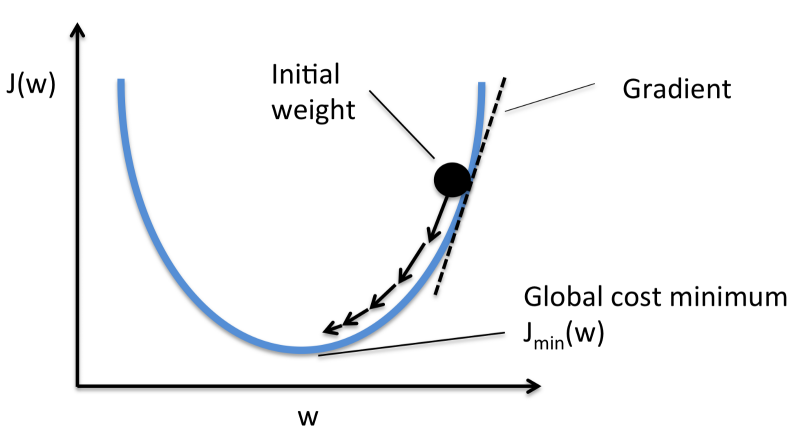

경사 하강법을 사용하면 비용 함수 <i>J(w)</i>의 그래디언트 ∇<i>J(w)</i> 반대 방향으로 조금씩 가중치를 업데이트한다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Ada_w.png">
</div>

가중치 변화량 Δ<i>w</i>는 음수의 그래디언트 학습률 <i>η</i>를 곱한 것으로 정의한다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Ada_w_01.png">
</div>

비용 함수의 그래디언트를 계산하려면 각 가중치 <i>w<sub>j</sub></i> 에 대한 편도 함수를 계산해야 한다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Ada_w_02.png">
</div>

따라서 가중치 <i>w<sub>j</sub></i>의 업데이트 공식을 다음과 같이 쓸 수 있다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Ada_w_03.png">
</div>

모든 가중치가 동시에 업데이트되기 때문에 아달린 학습 규칙은 다음과 같다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/Ada_w.png">
</div>

아달린 학습 규칙이 퍼셉트론과 동일하게 보이지만 <i>z<sup>(i)</sup></i> = <b>w</b><sup>T</sup><b>x</b><sup>(i)</sup>인 <i>Φ(z<sup>(i)</sup>)</i>는 정수 클래스 레이블이 아니고 실수이다. 또 훈련 세트에 있는 모든 샘플을 기반으로 가중치 업데이트를 계산한다(각 샘플마다 업데이트하지는 않는다). 이 방식을 <b>배치 경사 하강법</b><sup>batch gradient descent</sup>이라고도 한다.

## 파이썬으로 아달린 구현

퍼셉트론 규칙과 아달린이 매우 비슷하기 때문에 앞서 정의한 퍼셉트론 구현에서 <code>fit()</code>메서드를 바꾸어 경사 하강법으로 비용 함수가 최소화되도록 가중치를 업데이트한다.

In [45]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

퍼셉트론처럼 개별 훈련 샘플마다 평가한 후 가중치를 업데이트하지 않고 전체 훈련 데이터셋을 기반으로 그래디언트를 계산한다. 절편(0번째 가중치)은 <code>self.eta * errors.sum()</code>이고<sup id="a08">[8](#p08)</sup> 가중치 1에서 m까지는 <code>self.eta * X.T.dot(errors)</code>이다. 여기서 <code>X.T.dot(errors)</code>는 특성 행렬과 오차 벡터 가의 행렬-벡터 곱셈이다.

이 코드의 <code>activation()</code>메서드는 단순한 항등 함수<sup>identity function</sup>이기 때문에 아무런 영향을 미치지 않는다. 단일층 신경망을 통해 정보가 어떻게 흘러가는지를 표시하려고 (<code>activation()</code> 메서드에서 계산되는) 활성화 함수를 추가했다. 입력 데이터의 특성에서 최종 입력, 활성화, 출력 순으로 진행된다. 후에 다룰 비선형 활성화 함수를 사용하는 로지스틱 회귀 모델은 활성화 함수와 비용 함수만 다르고 아달린과 매우 비슷하다.

이전 퍼셉트론 구현과 마찬가지로 비용을 <code>self.cost_</code> 리스트에 모아서 알고리즘이 훈련으로 수렴하는지 확인해 보겠다.

실전에서는 최적으로 수렴하는 좋은 학습률 <i>η</i>를 찾기 위해 여러 번 실험을 해야 한다. 두 개의 학습률 <i>η</i>=0.1과 <i>η</i>=0.0001을 선택해 보자. 에포크 횟수 대비 비용 함수의 값을 그래프로 나타내면 아달린 구현이 훈련 데이터에서 얼마나 잘 학습하는지 볼 수 있다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 에포크 횟수(n_iter)와 학습률 <i>η</i>(eta)는 퍼셉트론과 아달린 학습 알고리즘의 하이퍼파라미터이다. 나중에는 모델이 최적의 성능을 내기 위해 다양한 하이퍼파라미터 값을 자동으로 찾을 것이다.
</div>

두 학습률에서 에포크 횟수 대비 비용 그래프를 그려 본다.

그림 저장: ada_converage_by_eta


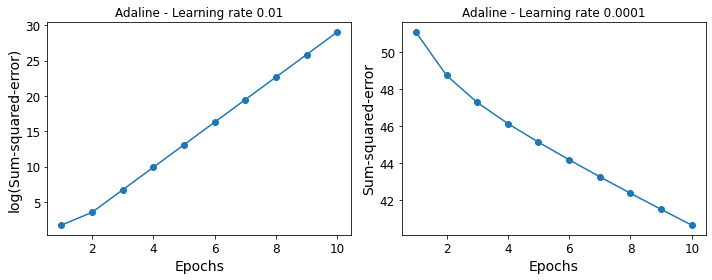

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1= AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1),
           np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1),
           ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')
save_fig('ada_converage_by_eta')
plt.show()

출력된 비용 함수 그래프에서 볼 수 있듯이 두 개의 다른 문제가 발생했다. 위 그림의 왼쪽 그래프는 학습률이 너무 클 때 발생한다. 비용 함수를 최소화하지 못하고 오차는 에포크마다 점점 더 커진다. 전역 최솟값을 지나쳤기 때문이다. 반면 오른쪽 그래프에서는 비용이 감소하지만 학습률 <i>η</i>=0.0001은 너무 작기 때문에 알고리즘이 전역 최솟값에 수렴하려면 아주 많은 에포크가 필요하다.

다음 그림은 비용 함수 J를 최소화하려고 특정 가중치 값을 바꾸었을 때 어떤 일이 일어나는지 보여 준다. 왼쪽 그림은 적절하게 선택한 학습률의 경우이다. 비용이 점차 감소하여 전역 최솟값의 방향으로 이동한다. 오른쪽 그림은 너무 큰 학습률을 선택하여 전역 최솟값을 지나쳤다.

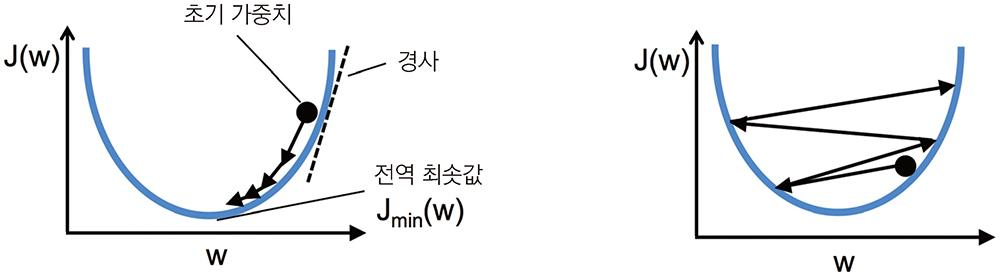

## 특성 스케일을 조정하여 경사 하강법 결과 향상

일부 머신 러닝 알고리즘들(트리 기반 알고리즘)을 제외한 대부분은 최적의 성능을 위해 어떤 식으로든지 특성 스케일을 조정하는 것이 필요하다.

경사 하강법은 특성 스케일을 조정하여 혜택을 볼 수 있는 많은 알고리즘 중 하나다. 이 절에서는 <b>표준화</b><sup>standardization</sup>라고 하는 특성 스케일 방법을 사용하겠다. 데이터에 표준 정규 분포의 성질을 부여하여 경사 하강법 학습이 좀 더 빠르게 수렴되도록 돕는다. 표준화는 각 특성의 평균을 0에 맞추고 특성의 표준 편차를 1로 만든다. 예를 들어 <i>j</i>번째 특성을 표준화하려면 모든 샘플에서 평균 <i>μ<sub>j</sub></i>를 빼고 표준 편차 <i>σ<sub>j</sub></i>로 나누면 된다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/standardization.png">
</div>

여기서 <i><b>x</b><sub>j</sub></i>는 n개의 모든 훈련 샘플에서 j번째 특성 값을 포함한 벡터이다. 표준화 기법을 데이터셋의 각 특성 j에 적용한다. 표준화가 경사 하강법 학습에 도움이 되는 이유 중 하나는 다음 그림에 나온 것처럼 더 적은 단계를 거쳐 최적 혹은 좋은 솔루션을 찾기 때문이다. 다음 그림은 2차원 분류 문제에서 모델의 가중치에 따른 비용 함수의 등고선을 보여 준다.

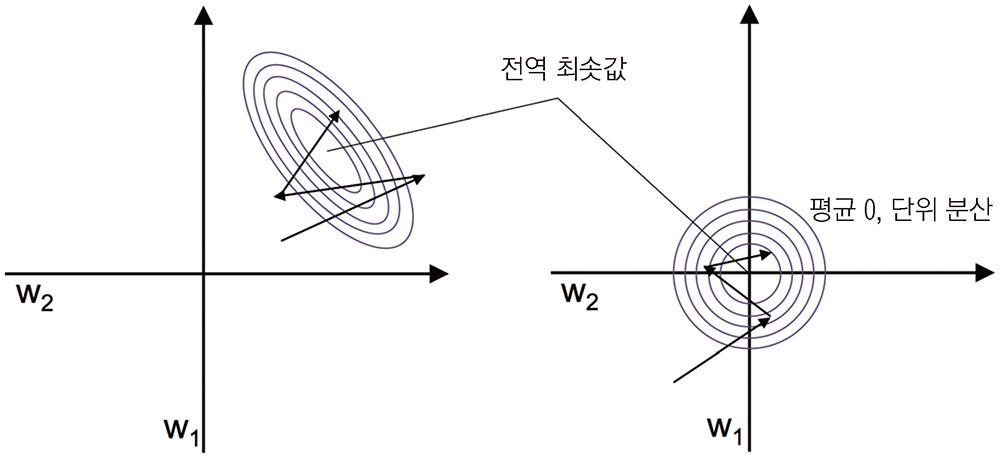

표준화는 넘파이 내장 함수 <code>mean()</code>과 <code>std()</code>로 간단하게 처리할 수 있다.

In [47]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

표준화한 후 다시 아달린 모델을 훈련하고 학습률 <i>η</i>=0.01에서 몇 번의 에포크만에 수렴하는지 확인해 보겠다.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_89640\3284501193.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


그림 저장: ada_decision_regions


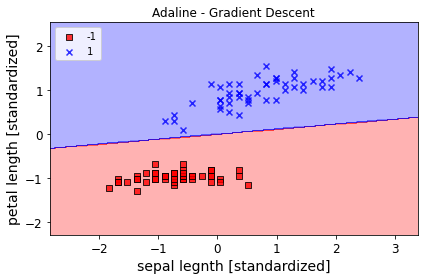

그림 저장: ada_learning_curve


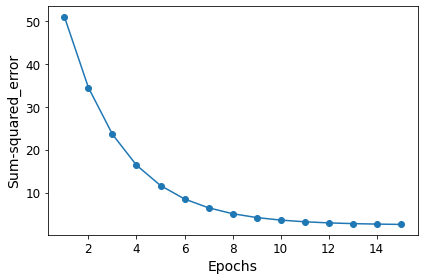

In [50]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal legnth [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
save_fig('ada_decision_regions')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared_error')
save_fig('ada_learning_curve')
plt.show()

이 그래프에서 볼 수 있듯이 학습률 <i>η</i>=0.01을 사용하고 표준화된 특성에서 훈련하니 아달린 모델이 수렴했다. 모든 샘플이 완벽하게 분류되더라도 SSE가 0이 되지는 않는다.

특성 스케일에 대한 추가적인 내용은 다음 링크에서 <b>특성 스케일링</b>부분을 참고하자.<br><a href='https://github.com/Sameta-cani/jwork/blob/master/ml03.ipynb' target='blank'>https://github.com/Sameta-cani/jwork/blob/master/ml03.ipynb</a>

## 대규모 머신 러닝과 확률적 경사 하강법

이전 절에서 전체 훈련 세트에서 계산한 그래디언트의 반대 방향으로 한 걸음씩 진행하여 비용 함수를 최소화하는 방법을 배웠다. 이 방식을 이따금 <b>배치 경사 하강법</b>이라고도 부른다. 수백만 개의 데이터 포인트가 있는 매우 큰 데이터셋을 생각해 보자. 많은 머신 러닝 애플리케이션에서 이런 데이터셋은 드문 일이 아니다. 이때 배치 경사 하강법을 실행하면 계산 비용이 매우 많이 든다. 전역 최솟값으로 나아가는 단계마다 매번 전체 훈련 데이터셋을 다시 평가해야 하기 때문이다.

<b>확률적 경사 하강법</b><sup>stochastic gradient descent</sup>은 배치 경사 하강법의 다른 대안으로 인기가 높다. 이따금 반복 또는 온라인 경사 하강법이라고 부른다. 다음 첫 번째 수식처럼 모든 샘플 <i><b>x</b><sup>(i)</sup></i>에 대하여 누적된 오차의 합을 기반으로 가중치를 업데이트하는 대신 두 번째 수식처럼 각 훈련 샘플에 대해서 조금씩 가중치를 업데이트한다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/sgd_training_w.png">
</div>

확률적 경사 하강법을 경사 하강법의 근사로 생각할 수 있지만 가중치가 더 자주 업데이트되기 때문에 수렴 속도가 훨씬 빠르다. 그래디언트가 하나의 훈련 샘플을 기반으로 계산되므로 오차의 궤적은 배치 경사 하강법보다 훨씬 어지럽다. 비선형 비용 함수를 다룰 때 얕은 지역 최솟값을 더 쉽게 탈출할 수 있어 장점이 되기도 한다. 확률적 경사 하강법에서 만족스러운 결과를 얻으려면 훈련 샘플 순서를 무작위하게 주입하는 것이 중요하다. 또 순환되지 않도록 에포크마다 훈련 세트를 섞는 것이 좋다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 확률적 경사 하강법 구현에서 종종 고정된 학습률 <i>η</i>를 시간이 지남에 따라 적응적인 학습률로 대체한다. 예를 들어 다음과 같다.<br><br>
    <div style="text-align : center;">
     <img src="./images/formula/ml04/sgd_learning_rate.png">
</div>
    <br>여기서 <i>c</i><sub>1</sub>과 <i>c</i><sub>2</sub>는 상수다. 확률적 경사 하강법은 전역 최솟값에 도달하지 못하지만 매우 가까운 지역에 근접한다. 적응적 학습률을 사용하면 최솟값에 더욱 가깝게 다가갈 수 있다.
</div>

확률적 경사 하강법의 또 다른 장점은 <b>온라인 학습</b><sup>online learning</sup>으로 사용할 수 있다는 것이다. 온라인 학습에서 모델은 새로운 훈련 데이터가 도착하는 대로 훈련된다. 많은 양의 훈련 데이터가 있을 때도 유용하다. 예를 들어 고객 데이터를 처리하는 웹 애플리케이션이다. 온라인 학습을 사용해서 시스템은 변화에 즉시 적응한다. 저장 공간에 제약이 있다면 모델을 업데이트한 후 훈련 데이터를 버릴 수 있다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 배치 경사 하강법과 확률적 경사 하강법 사이의 절충점이 <b>미니 배치 학습</b><sup>mini-batch learning</sup>이다. 미니 배치 학습은 훈련 데이터의 작은 일부분으로 배치 경사 하강법을 적용한다고 이해할 수 있다. 예를 들어 한번에 32개의 샘플을 사용한다. 배치 경사 하강법에 비해 장점은 가중치 업데이트가 더 자주 일어나므로 수렴 속도가 더 빠르다. 또 미니 배치 학습은 확률적 경사 하강법에서 훈련 샘플을 순회하는 for 반복을 벡터화된 연산으로 바꾸어 주므로 학습 알고리즘의 계산 효율성이 크게 향상된다.
</div>

경사 하강법으로 아달린 학습 규칙을 구현했기 때문에 학습 알고리즘을 조금만 수정하면 확률적 경사 하강법으로 가중치를 업데이트할 수 있다. <code>fit()</code>메서드 안에서 각 훈련 샘플에 대해 가중치를 업데이트할 것이다. 추가로 <code>partial_fit()</code>메서드도 구현하겠다. 이 메서드는 가중치를 다시 초기화하지 않아 온라인 학습에서 사용할 수 있다. 훈련 후에는 알고리즘이 수렴하는지 확인하려고 에포크마다 훈련 샘플의 평균 비용을 계산한다. 비용 함수를 최적화할 때 반복적인 순환이 일어나지 않도록 매 에포크가 일어나기 전에 훈련 샘플을 섞는 옵션을 추가한다. random_state 매개변수로는 재현 가능하도록 랜덤 시드를 지정할 수 있다.

In [53]:
class AdalineSGD(object):
    """ADAptive LInear NEuron 분류기

    Parameters
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞습니다
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    Attributes
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃 벡터

        반환값
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습합니다"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터를 섞습니다"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """랜덤한 작은 수로 가중치를 초기화합니다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트합니다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

AdalineSGD 분류기에서 사용하는 <code>_shuffle()</code>메서드는 다음과 같이 작동한다. np.random 모듈의 <code>permutation()</code>함수로 0에서 100까지 중복되지 않은 랜덤한 숫자 시퀀스<sup>sequence</sup>를 생성한다. 이 숫자 시퀀스를 특성 행렬과 클래스 레이블 벡터를 섞는 인덱스로 사용한다.

그다음 <code>fit()</code>메서드로 AdalineSGD 분류기를 훈련하고, <code>plot_decision_regions()</code>로는 훈련 결과를 그래프로 그린다.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_89640\3284501193.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


그림 저장: Adaline_Stochastic_Gradient_Descent


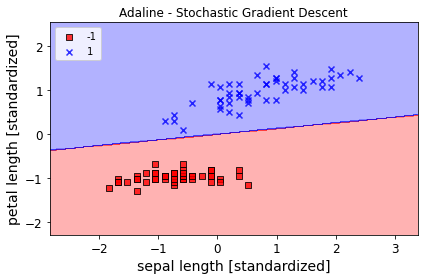

그림 저장: Average_Cost


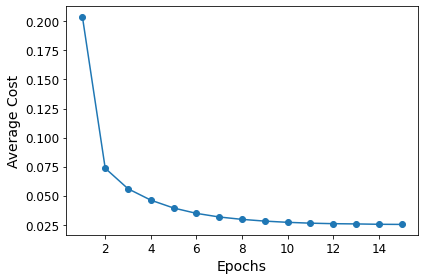

In [54]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
save_fig('Adaline_Stochastic_Gradient_Descent')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
save_fig('Average_Cost')
plt.show()

여기서 보듯이 평균 비용이 상당히 빠르게 감소한다. 15번째 에포크 이후 최종 결정 경계는 배치 경사 하강법과 거의 비슷해 보인다. 스트리밍 데이터를 사용하는 온라인 학습 방식으로 모델을 훈련하려면 개개의 샘플마다 <code>partial_fit()</code>메서드를 호출하면 된다. 예를 들어 <code>ada.partial_fit(X_std[0, :], y[0])과 같다.

# 각주

<b id="p01">1</b> A Logical Calculus of the Ideas Immanent in Nervous Activity, W. S. McCulloch and W. Pitts, Bulletin of Mathematical Biophysics, 5(4): 115-113, 1943[↩](#a01)

<b id="p02">2</b> The Perceptron: A Perceiving and Recognizing Automaton, F.Rosenblatt, Cornell Aeronautical Laboratory, 1957[↩](#a02)

<b id="p03">3</b> 단위 계단 함수는 <i>z</i> ≥ 0일 때 1, 그렇지 않으면 0을 반환하는 함수이다.[↩](#a03)

<b id="p04">4</b> 입력과 가중치의 가중 합이 0인 식이 2차원이면 직선 방정식이 되지만, 3차원이면 평면 방정식이 되고 n차원이면 초평면<sup>hyperplane</sup> 방정식이된다. 이들은 모두 공간을 둘로 나눈다는 특징이 있다.[↩](#a04)

<b id="p05">5</b> 환원주의는 복잡하고 추상적인 개념을 더 단순한 요소로 명확하게 정의할 수 있다는 믿음이다. 예를 들어 생물의 어떤 현상을 물리적, 화학적으로 설명할 수 있다록 주장한다.[↩](#a05)

<b id="p06">6</b> iris.data 파일은 iris-setosa, iris-versicolor, iris-virginica가 순서대로 50개씩 들어 있는 CSV 파일이다.[↩](#a06)

<b id="p07">7</b> An Adpative "Adaline" Neuron Using Chemical "Memistors", Technical Report Number 1553-2, B. Widrow and others, Stanford Electron Labs, Standford, CA, October 1960[↩](#a07)

<b id="p08">8</b> <i>w<sub>0</sub></i>에 대한 그래디언트는 <i>x<sub>0</sub></i>가 1이므로 SSE 비용 함수의 편도 함수에서 오차의 합만 남는다.[↩](#a08)